In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
import numpy
import logging
import numpy as np
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import matplotlib
from matplotlib import pyplot
from matplotlib import pyplot as plt
pyplot.style.use("tlrh")

# This repo: src folder /w Python scripts
sys.path.append("../src")
# Other repos linked into the notebook container ;-)
sys.path.append("../../supaharris")
from data.parse_hilker_2019 import parse_individual_rvs_of_stars_in_field_of_clusters
sys.path.append("../../supaharris-client")
from supaharrisclient.utils import suppress_stdout
from supaharrisclient.client import SupaHarrisClient

logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

In [4]:
# It seems that the logger propagates ..
# shc = SupaHarrisClient(base_url="https://nginx/api/v1/", loglevel=logging.CRITICAL, verify=False)

In [5]:
# Because explicit is better than implicit
from galpy.potential.PowerSphericalPotentialwCutoff import PowerSphericalPotentialwCutoff
from galpy.potential.MiyamotoNagaiPotential import MiyamotoNagaiPotential
from galpy.potential.TwoPowerSphericalPotential import NFWPotential
import galpy.util.bovy_conversion as conversion

# See Table 1 in galpy paper: Bovy (2014)
MWPotential2014= [
    # alpha: inner power; rc: cut-off radius
    PowerSphericalPotentialwCutoff(normalize=0.05, alpha=1.8, rc=1.9/8.),  # bulge
    # a: scale length, b: scale height. Do these numbers mean disk is 3kpc long, 280 parsec thick?\
    # sensible size could be 30kpc, thickness 1kpc?). But scale length/heigth goes into exponent, != max. size / extent of disk
    MiyamotoNagaiPotential(a=3./8., b=0.28/8., normalize=0.6),  # disk 
    NFWPotential(a=2., normalize=0.35)  # dark matter
]

# The normalize=1. option normalizes the potential such that the radial force
# is a fraction normalize=1. of the radial force necessary to make the
# circular velocity 1 at R=1

# To work on the different components of the potential
bulge = MWPotential2014[0]
disk = MWPotential2014[1]
dm = MWPotential2014[2]

# Because units
from galpy.util import bovy_conversion
to_msun = bovy_conversion.mass_in_msol(dm._vo, dm._ro)
to_msunpc3 = bovy_conversion.dens_in_msolpc3(dm._vo, dm._ro)

# What does the disk in MWPotential2014 (Bovy 2015) look like?

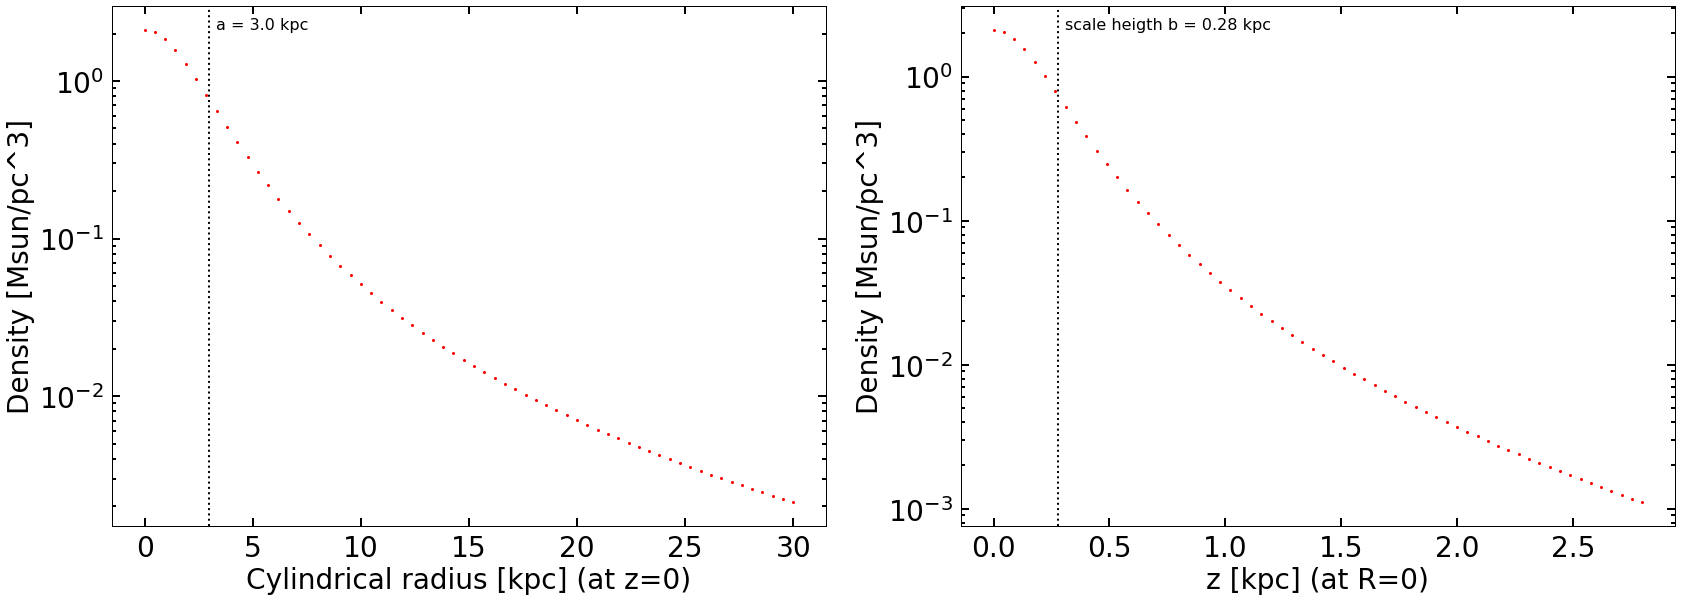

/usr/local/lib/python3.7/site-packages/galpy/util/bovy_plot.py:646: UserWarning: The following kwargs were not used by contour: 'aspect'
  linestyles=cntrls,origin=origin)



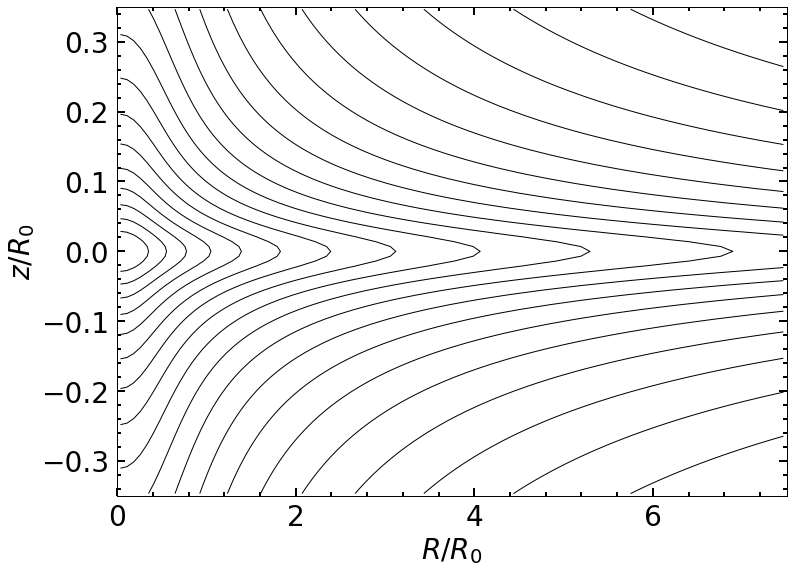

In [6]:
fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(24, 9))

for r in numpy.linspace(0, 30, 64):
    ax.plot(r, disk.dens(r*u.kpc, z=0*u.kpc)*to_msunpc3, "ro")

ax.set_xlabel("Cylindrical radius [kpc] (at z=0)")
ax.set_ylabel("Density [Msun/pc^3]")
# ax.set_xscale("log")
ax.set_yscale("log")

# a=3, so where is it?
ax.axvline(3., c="k", ls=":", lw=2)
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.text(3.*1.1, 0.98, "a = 3.0 kpc", ha="left", va="top", fontsize=16, transform=trans)

for z in numpy.linspace(0, 2.8, 64):
    ax2.plot(z, disk.dens(0*u.kpc, z=z*u.kpc)*to_msunpc3, "ro")

ax2.set_xlabel("z [kpc] (at R=0)")
ax2.set_ylabel("Density [Msun/pc^3]")
# ax2.set_xscale("log")
ax2.set_yscale("log")

# b=0.28, so where is it?
ax2.axvline(0.28, c="k", ls=":", lw=2)
trans = matplotlib.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
ax2.text(0.28*1.1, 0.98, "scale heigth b = 0.28 kpc", ha="left", va="top", fontsize=16, transform=trans)

pyplot.tight_layout()
pyplot.show(fig)

disk.plotDensity(rmin=0*u.kpc, rmax=60*u.kpc, zmin=-2.8*u.kpc, zmax=2.8*u.kpc, nrs=101, nzs=101, ncontours=21, log=True, justcontours=True)
pyplot.show()

# What does $M(<r)$ of MWPotential2014 (Bovy 2015) look like?

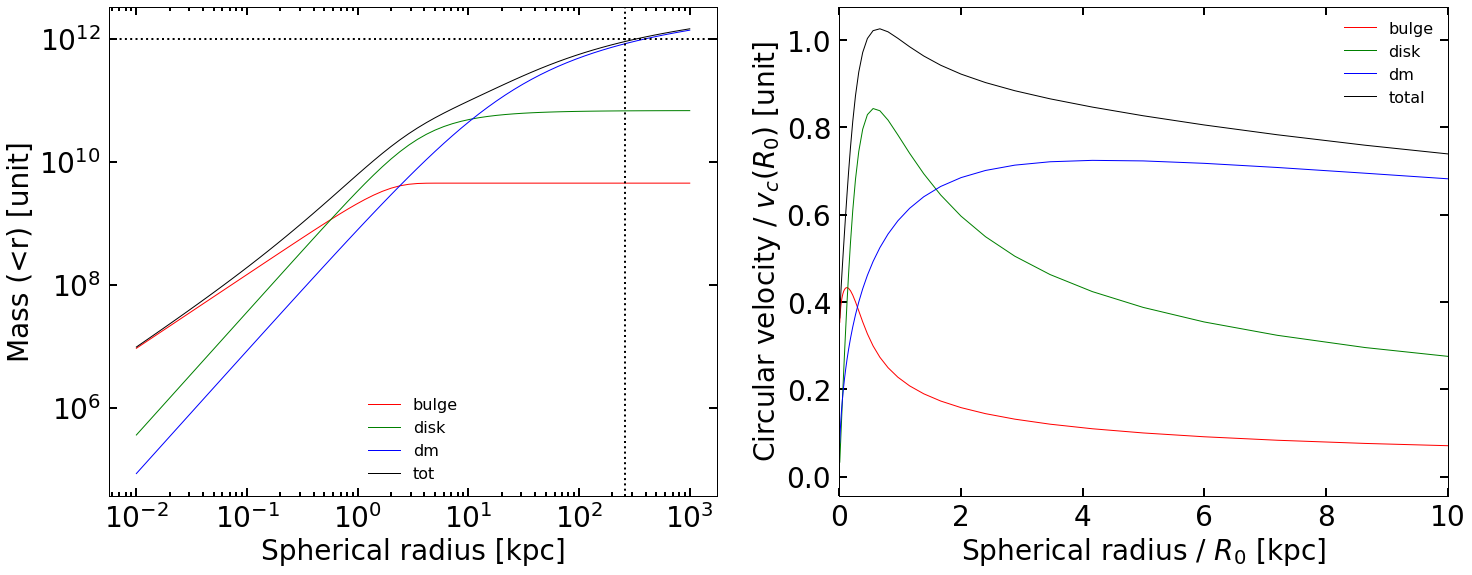

In [7]:
verbose = False

radii = numpy.logspace(-2, 3, 64)
Mbulge = numpy.zeros(radii.shape)
Mdisk = numpy.zeros(radii.shape)
Mdm = numpy.zeros(radii.shape)
Mtot = numpy.zeros(radii.shape) 

# Calculate mass for different components of the potential
for i, r in enumerate(radii):
    Mbulge[i] = bulge.mass(r*u.kpc) * to_msun
    Mdisk[i] = disk.mass(r*u.kpc, z=100*u.kpc, forceint=True) * to_msun
    Mdm[i] = dm.mass(r*u.kpc) * to_msun
    Mtot[i] = Mbulge[i] + Mdisk[i] + Mdm[i]
    if verbose: print("{0:<5.2f}{1:<5.2f}{2:<5.2f}{3:<5.2f}".format(r, Mbulge[i], Mdisk[i], Mdm[i], Mtot[i]))
        

fig, (ax, ax2) = pyplot.subplots(1, 2, figsize=(24, 9))
      
ax.plot(radii, Mbulge, c="red", label="bulge")
ax.plot(radii, Mdisk, c="green", label="disk")
ax.plot(radii, Mdm, c="blue", label="dm")
ax.plot(radii, Mtot, c="black", label="tot")

# Indicate expected mass of the Galaxy to see if calculation makes sense
# Parel+ (2017) --> Rvir,MW = 261 kpc /w Mvir,MW = 1e12 O_o?
ax.axhline(1e12, c="k", ls=":", lw=2)
ax.axvline(261, c="k", ls=":", lw=2)

ax.set_xlabel("Spherical radius [kpc]")
ax.set_ylabel("Mass (<r) [unit]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(fontsize=16, loc="best", frameon=False)


from galpy.potential import vcirc
ax2.plot(radii, vcirc(bulge, radii), c="red", label="bulge")
ax2.plot(radii, vcirc(disk, radii), c="green", label="disk")
ax2.plot(radii, vcirc(dm, radii), c="blue", label="dm")
ax2.plot(radii, vcirc(MWPotential2014, radii), c="black", label="total")

ax2.set_xlabel("Spherical radius / $R_0$ [kpc]")
ax2.set_ylabel("Circular velocity / $v_c(R_0)$ [unit]")
# ax2.set_xscale("log")
# ax2.set_yscale("log")
ax2.set_xlim(0, 10)
ax2.legend(fontsize=16, loc="best", frameon=False)


pyplot.show(fig)

In [9]:
from data.parse_hilker_2019 import parse_hilker_2019_combined
from data.parse_hilker_2019 import parse_hilker_2019_orbits
hilker_combined = parse_hilker_2019_combined(logger, debug=True)
hilker_orbits = parse_hilker_2019_orbits(logger, debug=True)

data = []
verbose = True
if verbose: 
    print("{0:<15s}{1:>10s}{2:>10s}{3:>10s}{4:>10s}{5:>10s}{6:>10s}{7:>10s}{8:>10s}".format(
        "GC", "Mass", "R_GC", "Rperi", "Rapo", "M(<Rperi)", "rt (H19)", "rt (1e12)", "rt (calc)")
    )
for gc_name, gc_mass, rgal, rt_hilker in zip(
        hilker_combined["Cluster"], hilker_combined["Mass"],
        hilker_combined["R_GC"], hilker_combined["rt"]
    ):
    
    imatch, = numpy.where(hilker_orbits["Cluster"] == gc_name)
    if len(imatch) == 1:
        Rperi = hilker_orbits["RPERI"][imatch][0]
        Rapo = hilker_orbits["RAP"][imatch][0]
    else:
        print("{0} not in hilker_orbits".format(gc_name))
    
    # Here we simply plug in the distance to the center of the Galaxy, as per Spitzer 1987 eq. 1-33
    # However, the equation is valid for two point masses on a circular orbit. GC orbits aren't quite
    # circular, so according to TODO-ADD-REF the equation would still be valid if Rperi is used instead.
    # Furthermore, we need to use the enclosed mass of the Galaxy, i.e. Mgal(<Rperi). 
    iMgal_enclosed, = numpy.where(radii < Rperi)
    Menclosed = Mtot[iMgal_enclosed[-1]]  # Msun
    tidal_radius = numpy.power(gc_mass*(rgal*1e3)**3/(2*Menclosed), 1.0/3)  # parsec
    tidal_radius_wrong = numpy.power(gc_mass*(rgal*1e3)**3/(2*1e12), 1.0/3)  # parsec
    if verbose: 
        print("{0:<15s}{1:>10.2e}{2:>10.2f}{3:>10.2f}{4:>10.2f}{5:>10.2e}{6:>10.2f}{7:>10.2f}{8:>10.2f}".format(
            gc_name, gc_mass, rgal, Rperi, Rapo, Menclosed, rt_hilker, tidal_radius_wrong, tidal_radius)
        )
    
    data.append([tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Rapo, gc_mass, Menclosed])
data = numpy.array(data)

GC                   Mass      R_GC     Rperi      Rapo M(<Rperi)  rt (H19) rt (1e12) rt (calc)
NGC 104          7.61e+05      7.78      5.46      7.44  5.20e+10    119.31     56.38    151.02
NGC 288          1.21e+05     13.17      3.33     13.01  2.86e+10     98.54     51.70    168.97
NGC 362          3.33e+05     10.00      1.05     12.48  5.90e+09    110.38     55.01    304.44
Whiting 1        1.51e+03     36.05     17.64     53.27  1.36e+11     38.14     32.83     63.76
NGC 1261         1.86e+05     17.62      1.41     19.93  1.04e+10    122.10     79.83    365.46
Pal 1            1.79e+03     17.52     14.23     18.74  1.17e+11     25.69     16.88     34.53
AM 1             3.17e+04    124.72     98.84    308.34  5.36e+11    310.95    313.29    385.73
Eridanus         1.11e+04     95.37     33.56    134.93  2.49e+11    138.51    168.85    268.39
Pal 2            2.32e+05     35.53      2.49     39.41  2.28e+10    216.64    173.28    611.49
NGC 1851         2.83e+05     16.39     

In [10]:
imismatch, = numpy.where(hilker_combined["Cluster"] != hilker_orbits["Cluster"])
print(hilker_combined["Cluster"][imismatch])
print(hilker_orbits["Cluster"][imismatch])

['Liller 1' 'NGC 6522' 'Ter 10' '2MASS-GC01' 'ESO 280-SC06' 'NGC 6553'
 '2MASS-GC02' 'NGC 6558' 'IC 1276' 'Ter 12' 'NGC 6569' 'BH 261' 'NGC 6584']
['Lil 1' 'Ter 10' 'NGC 6522' 'ESO 280-SC06' 'NGC 6553' '2MASS-GC02'
 'NGC 6558' 'IC 1276' 'Ter 12' 'NGC 6569' 'BH 261' 'NGC 6584' 'Mercer 5']


# What does the distribution of log10(Rperi) and log10(rt) log like?

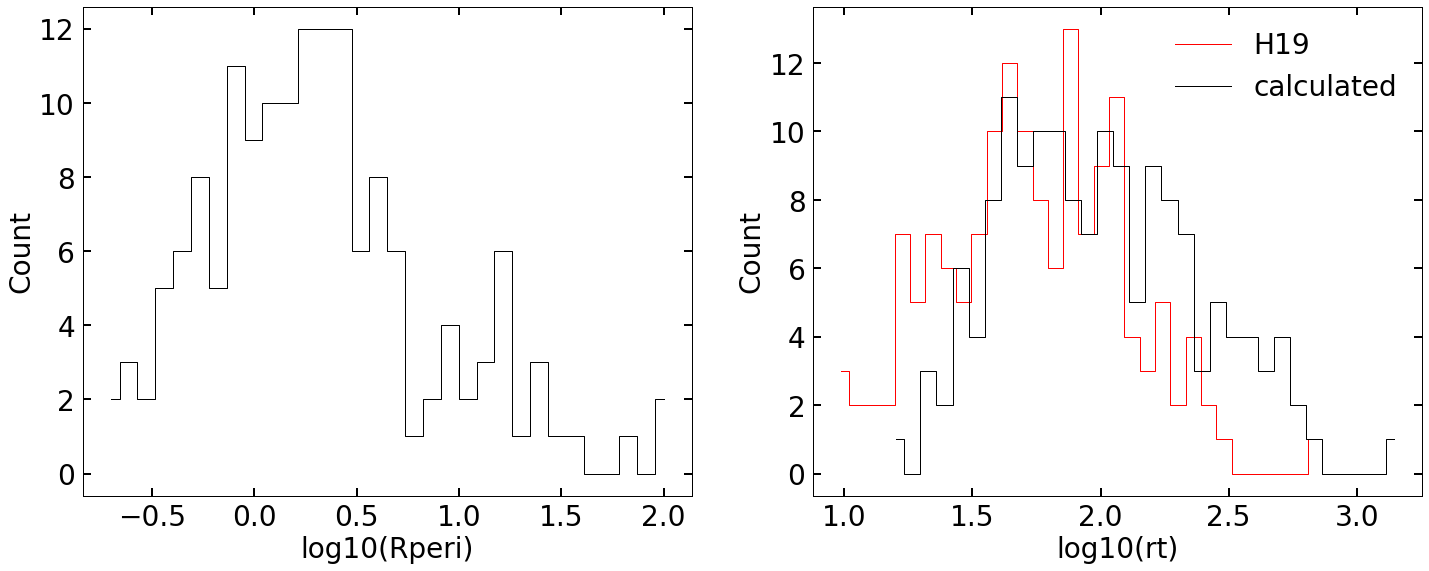

In [11]:
fig, (ax, ax1) = pyplot.subplots(1, 2, figsize=(24, 9))

# tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed
counts, edges = numpy.histogram(numpy.log10(data[:,3]), bins=32)
ax.plot((edges[1:]+edges[:-1])/2, counts, drawstyle="steps-mid", c="k")
ax.set_xlabel("log10(Rperi)")
ax.set_ylabel("Count")

# tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed
counts, edges = numpy.histogram(numpy.log10(data[:,2]), bins=32)
ax1.plot((edges[1:]+edges[:-1])/2, counts, label="H19", drawstyle="steps-mid", c="r")
counts, edges = numpy.histogram(numpy.log10(data[:,1]), bins=32)
ax1.plot((edges[1:]+edges[:-1])/2, counts, label="calculated", drawstyle="steps-mid", c="k")
ax1.set_xlabel("log10(rt)")
ax1.set_ylabel("Count")
ax1.legend(frameon=False)

pyplot.show()

# What does the plot /w wrong calculated tidal radius look like when colorcoded by Rperi? 

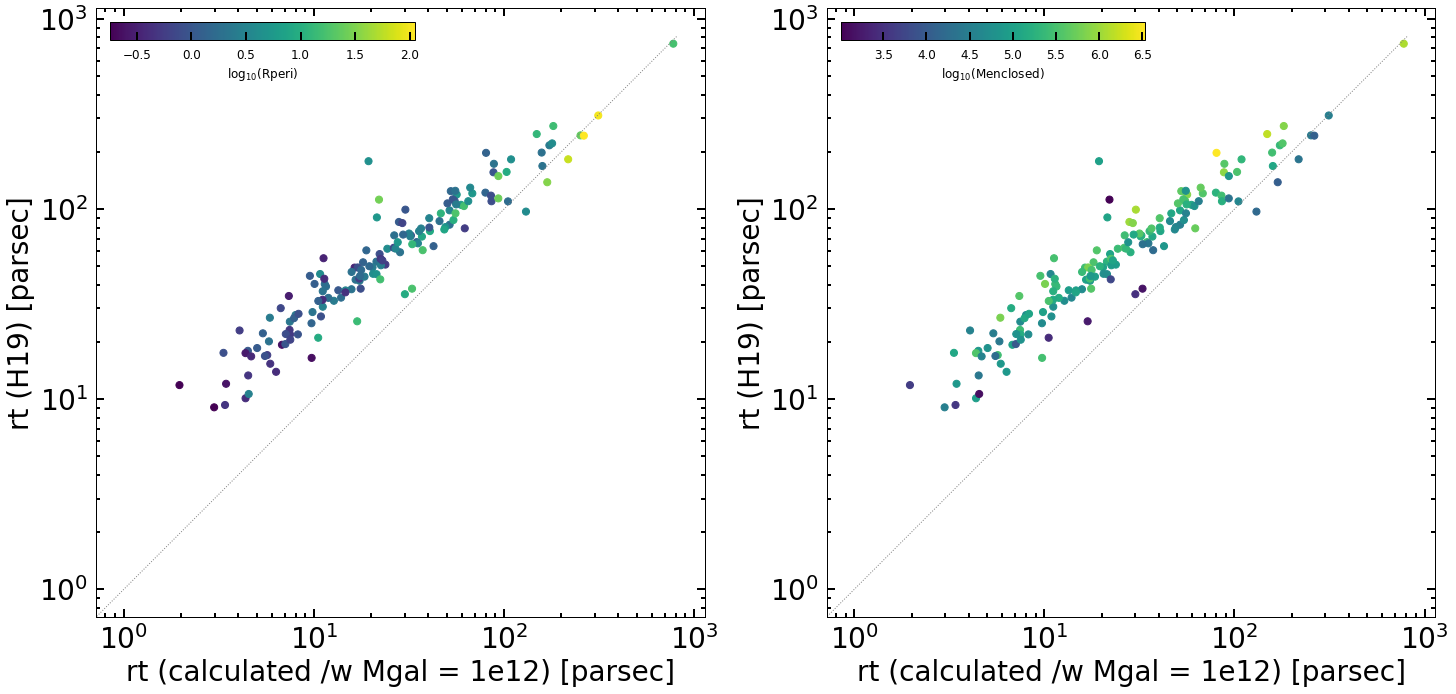

In [12]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

# tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Rapo, Menclosed
ax1.scatter(data[:,0], data[:,2], c=numpy.log10(data[:,3]), s=50, cmap="viridis")
ax2.scatter(data[:,0], data[:,2], c=numpy.log10(data[:,5]), s=50, cmap="viridis")

for ax, cax_xlabel in zip([ax1, ax2], ["Rperi", "Menclosed"]):
    x = numpy.arange(1.1*numpy.max(hilker_combined["rt"]))
    ax.plot(x, x, c="grey", lw=1, ls=":")
    ax.set_xlabel("rt (calculated /w Mgal = 1e12) [parsec]")
    ax.set_ylabel("rt (H19) [parsec]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect("equal")

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.show()

# What does rt_obs vs. rt_calculated look like when using Mgal(<Rperi)?

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



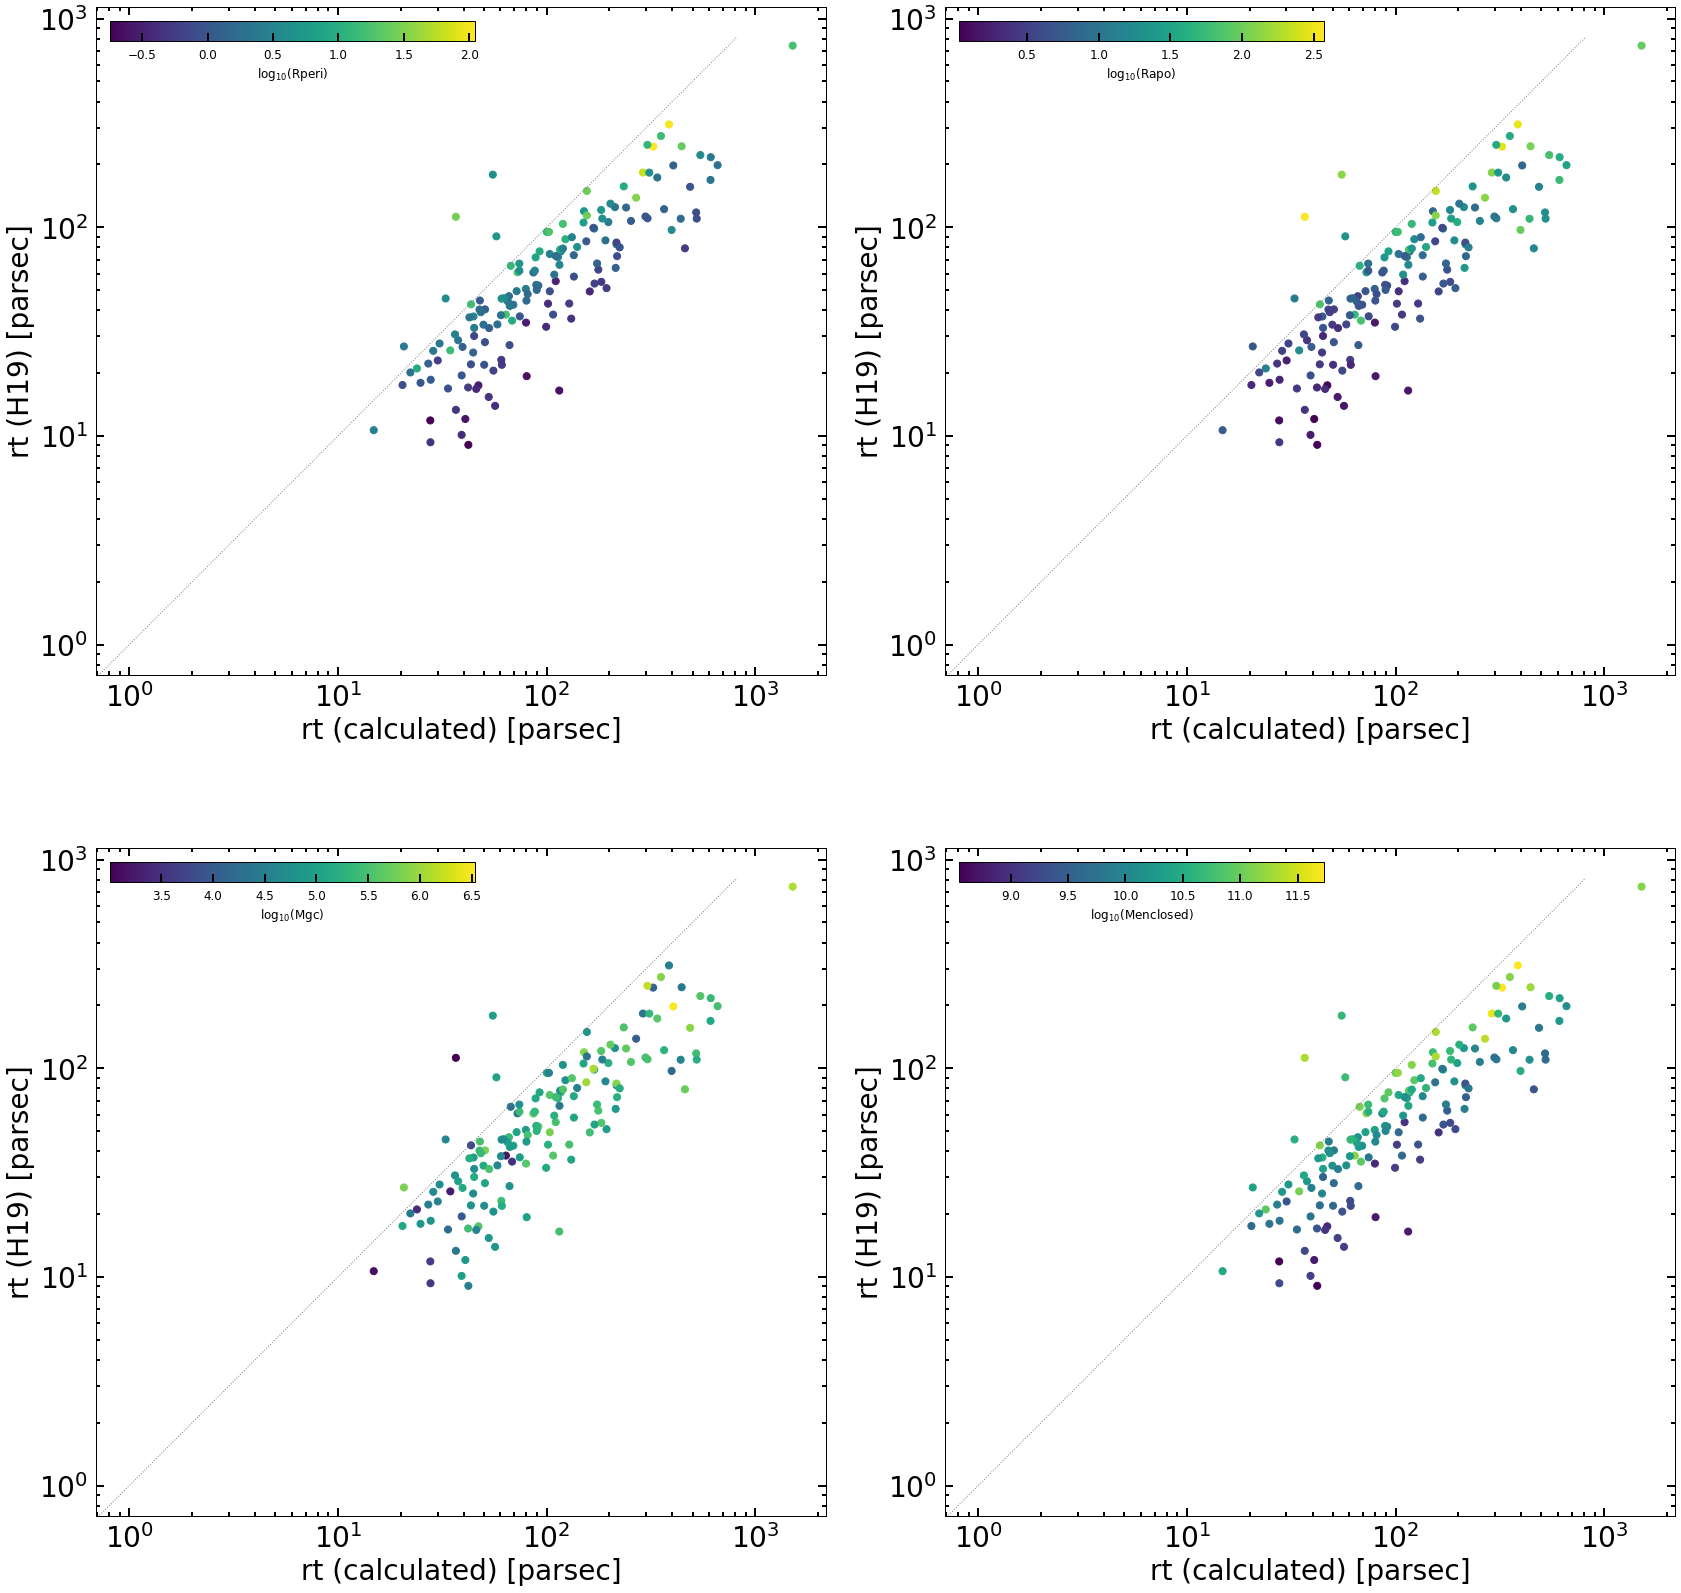

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = pyplot.subplots(2, 2, figsize=(24, 24))

# tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Mgc, Menclosed
ax1.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,3]), s=50, cmap="viridis")
ax2.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,4]), s=50, cmap="viridis")
ax3.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,5]), s=50, cmap="viridis")
ax4.scatter(data[:,1], data[:,2], c=numpy.log10(data[:,6]), s=50, cmap="viridis")

for ax, cax_xlabel in zip([ax1, ax2, ax3, ax4], ["Rperi", "Rapo", "Mgc", "Menclosed"]):
    x = numpy.arange(1.1*numpy.max(hilker_combined["rt"]))
    ax.plot(x, x, c="grey", lw=1, ls=":")
    ax.set_xlabel("rt (calculated) [parsec]")
    ax.set_ylabel("rt (H19) [parsec]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_aspect("equal")

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.tight_layout()
pyplot.show()

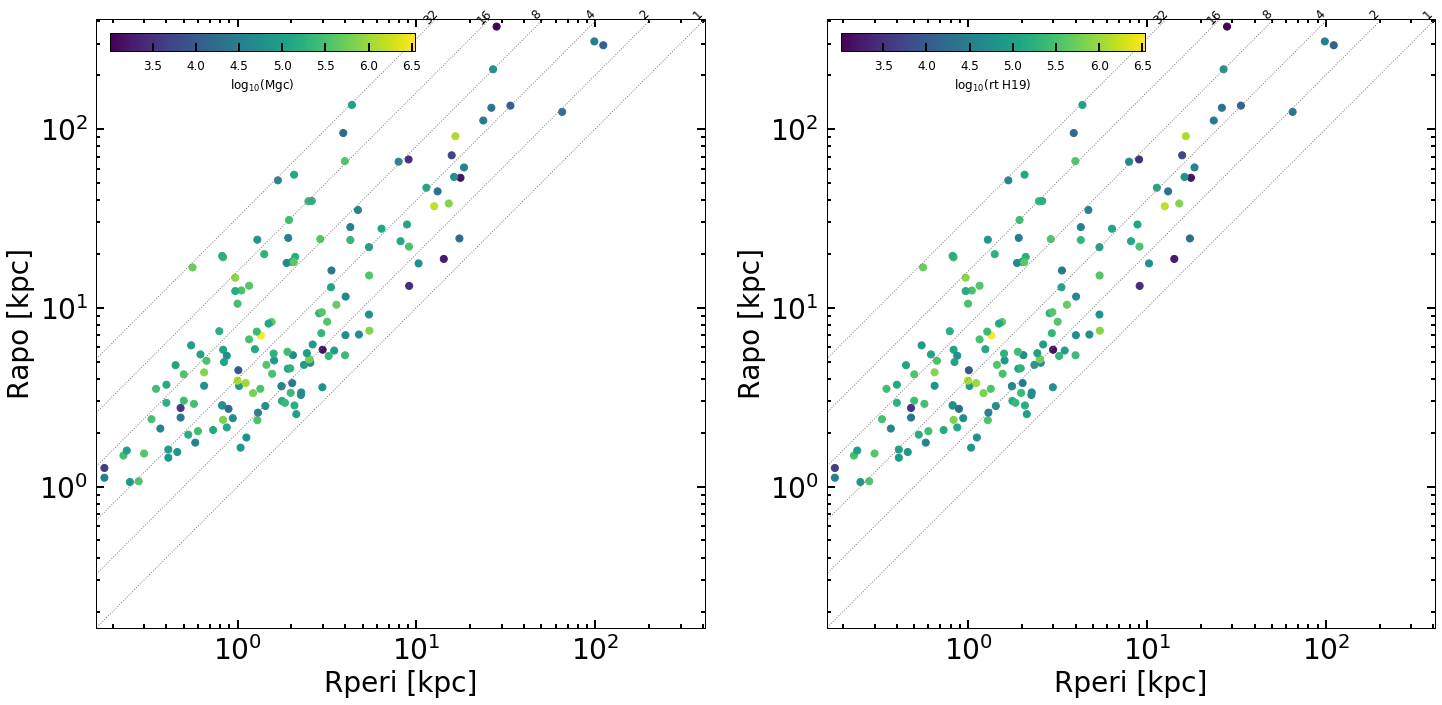

In [14]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

for ax, cax_xlabel in zip([ax1, ax2], ["Mgc", "rt H19"]):
    # tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed
    ax.scatter(data[:,3], data[:,4], c=numpy.log10(data[:,5]), s=50)

    x = numpy.arange(1.1*numpy.max(data[:,4]))
    trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for i in [1, 2, 4, 8, 16, 32]:
        ax.plot(x, i*x, c="grey", lw=1, ls=":")
        imax, = numpy.where(i*x > numpy.max(data[:,4]))
        ax.text(x[imax[0]], 1.02, i, ha="center", va="top", fontsize=12, rotation="45", transform=trans)

    ax.set_xlabel("Rperi [kpc]")
    ax.set_ylabel("Rapo [kpc]")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(0.9*numpy.min(data[:,3]), 1.1*numpy.max(data[:,4]))
    ax.set_ylim(0.9*numpy.min(data[:,3]), 1.1*numpy.max(data[:,4]))
    ax.set_aspect(1)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

pyplot.show()

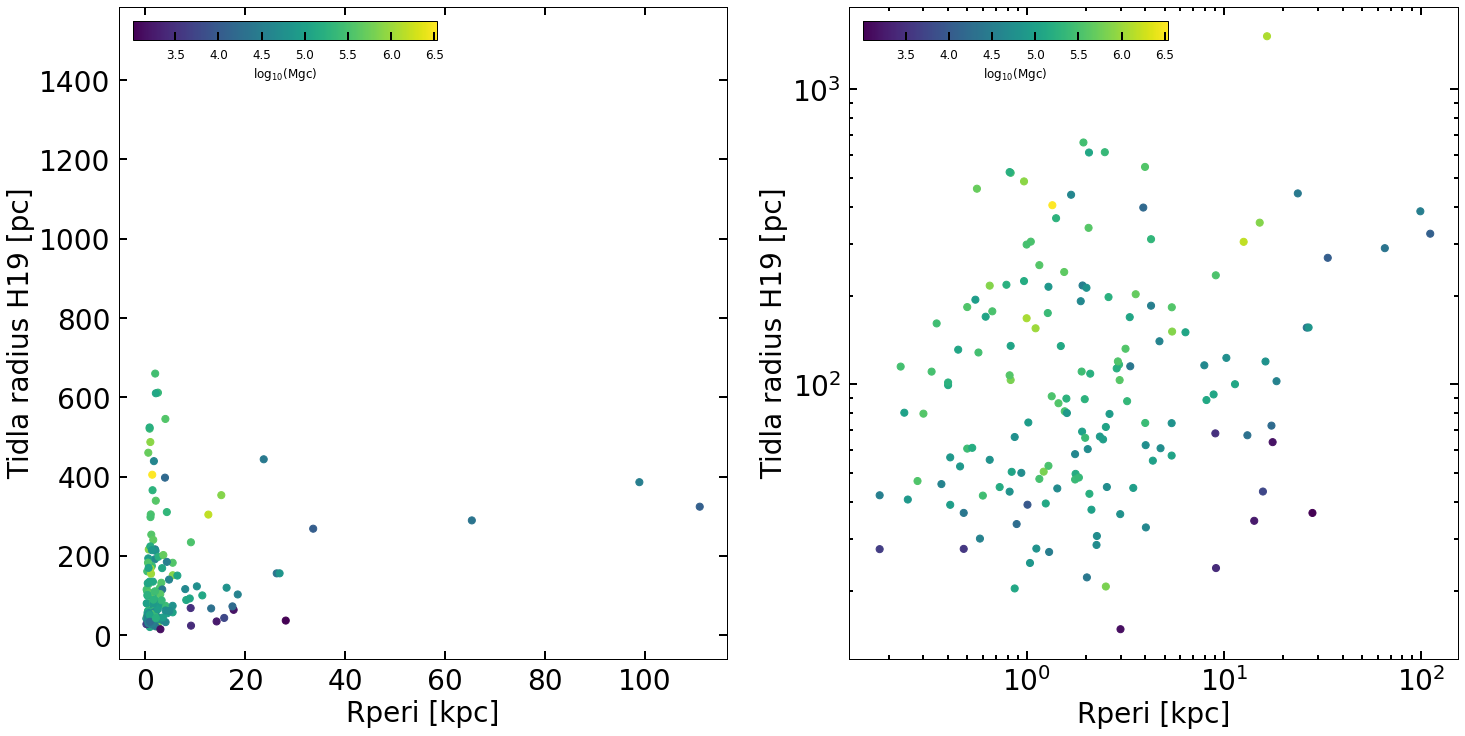

In [16]:
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(24, 12))

for ax in [ax1, ax2]:
    # tidal_radius_wrong, tidal_radius, rt_hilker, Rperi, Rapo, Mgc, Menclosed
    ax.scatter(data[:,3], data[:,1], c=numpy.log10(data[:,5]), s=50)

    ax.set_xlabel("Rperi [kpc]")
    ax.set_ylabel("Tidla radius H19 [pc]")

    cax_xlabel = "Mgc"
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    cbaxes = inset_axes(ax, width="50%", height="3%", loc="upper left") 
    cax = pyplot.colorbar(ax.get_children()[0], cax=cbaxes, orientation="horizontal")
    cax.ax.set_xlabel("log$_{{10}}$({0})".format(cax_xlabel), fontsize=12)
    cax.ax.tick_params(axis="both", which="major", labelsize=12)

ax2.set_xscale("log")
ax2.set_yscale("log")    

pyplot.show()